# Fine Tuning `BERT` for `Disaster Tweets` Classification


Text classification is a technique for putting text into different categories and has a wide range of applications: email providers use text classification to detect to spam emails, marketing agencies use it for sentiment analysis of customer reviews, and moderators of discussion forums use it to detect inappropriate comments.

In the past, data scientists used methods such as [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), [word2vec](https://en.wikipedia.org/wiki/Word2vec), or [bag-of-words (BOW)](https://en.wikipedia.org/wiki/Bag-of-words_model) to generate features for training classification models. While these techniques have been very successful in many NLP tasks, they don't always capture the meanings of words accurately when they appear in different contexts. Recently, we see increasing interest in using [Bidirectional Encoder Representations from Transformers (BERT)](https://arxiv.org/abs/1810.04805) to achieve better results in text classification tasks, due to its ability more accurately encode the meaning of words in different contexts.

BERT was trained on BookCorpus and English Wikipedia data, which contain 800 million words and 2,500 million words, respectively. Training BERT from scratch would be prohibitively expensive. By taking advantage of transfer learning, one can quickly fine tune BERT for another use case with a relatively small amount of training data to achieve state-of-the-art results for common NLP tasks, such as text classification and question answering. 

[Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/index.html) is a fully managed service that provides developers and data scientists with the ability to build, train, and deploy machine learning (ML) models quickly. Amazon SageMaker removes the heavy lifting from each step of the machine learning process to make it easier to develop high-quality models. The [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/) provides open source APIs and containers that make it easy to train and deploy models in Amazon SageMaker with several different machine learning and deep learning frameworks.

In this example, we walk through our dataset, the training process, and finally model deployment. 

# About the `Problem`

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies). However, identifying such tweets has always been a difficult task because of the ambiguity in the linguistic structure of the tweets and hence it is not always clear whether an individual’s words are actually announcing a disaster.

More details [here](https://www.kaggle.com/c/nlp-getting-started/overview)

<img src = "img/disaster.png" >

# Installation 

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


# Setup

To start, we import some Python libraries and initialize a SageMaker session, S3 bucket and prefix, and IAM role.

In [2]:
import os
import numpy as np
import pandas as pd
import sagemaker

sagemaker_session = sagemaker.Session()    # Provides a collection of methods for working with SageMaker resources

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-bert"

role = sagemaker.get_execution_role()      # Get the execution role for the notebook instance. 
                                           # This is the IAM role that we created for our notebook instance. 
                                           # We pass the role to the tuning job(later on).

# Prepare training data

Kaggle hosted a challenge named `Real` or `Not` whose aim was to use the Twitter data of disaster tweets, originally created by the company figure-eight, to classify Tweets talking about `real disaster` against the ones talking about it metaphorically. (https://www.kaggle.com/c/nlp-getting-started/overview)

### Get `sentences` and `labels`

Let us take a quick look at our data and for that we need to first read the training data. 
The only two columns we interested are:

- the `sentence` (the tweet)
- the `label`    (the label, this denotes whether a tweet is about a real disaster (1) or not (0))

In [4]:
df = pd.read_csv(
    "dataset/raw/data.csv",
    header=None,
    usecols=[1, 3],
    names=["label", "sentence"],
)


sentences = df.sentence.values
labels = df.label.values

In [5]:
df.tail()

,label,sentence
7608,1,Two giant cranes holding a bridge collapse int...
7609,1,@aria_ahrary @TheTawniest The out of control w...
7610,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,1,Police investigating after an e-bike collided ...
7612,1,The Latest: More Homes Razed by Northern Calif...


Printing few tweets with its class label 

In [6]:
list(zip(sentences[80:85], labels[80:85]))

[("mom: 'we didn't get home as fast as we wished' \nme: 'why is that?'\nmom: 'there was an accident and some truck spilt mayonnaise all over ??????",
  0),
 ("I was in a horrible car accident this past Sunday. I'm finally able to get around. Thank you GOD??",
  1),
 ('Can wait to see how pissed Donnie is when I tell him I was in ANOTHER accident??',
  0),
 ("#TruckCrash Overturns On #FortWorth Interstate http://t.co/Rs22LJ4qFp Click here if you've been in a crash&gt;http://t.co/Ld0unIYw4k",
  1),
 ('Accident in #Ashville on US 23 SB before SR 752 #traffic http://t.co/hylMo0WgFI',
  1)]

### Cleaning Text


As we can see from the above output, there are few information which are not that important, like `URLs`, `Emojis`, `Tags`, etc. So, now lets try to clean the dataset before we actually pass this data for training. 

In [7]:
import string
import re

In [8]:
# Helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)



In [9]:
df['sentence'] = df['sentence'].apply(lambda x: remove_URL(x))
df['sentence'] = df['sentence'].apply(lambda x: remove_emoji(x))
df['sentence'] = df['sentence'].apply(lambda x: remove_html(x))
df['sentence'] = df['sentence'].apply(lambda x: remove_punct(x))

In [10]:
df.head()

,label,sentence
0,1,Our Deeds are the Reason of this earthquake Ma...
1,1,Forest fire near La Ronge Sask Canada
2,1,All residents asked to shelter in place are be...
3,1,13000 people receive wildfires evacuation orde...
4,1,Just got sent this photo from Ruby Alaska as s...


In [11]:
sentences = df.sentence.values
labels = df.label.values

In [12]:
list(zip(sentences[80:85], labels[80:85]))

[('mom we didnt get home as fast as we wished \nme why is that\nmom there was an accident and some truck spilt mayonnaise all over ',
  0),
 ('I was in a horrible car accident this past Sunday Im finally able to get around Thank you GOD',
  1),
 ('Can wait to see how pissed Donnie is when I tell him I was in ANOTHER accident',
  0),
 ('TruckCrash Overturns On FortWorth Interstate  Click here if youve been in a crash',
  1),
 ('Accident in Ashville on US 23 SB before SR 752 traffic ', 1)]

# EDA

Let's spend couple of minutes to explore the dataset

## a) Data Distribution 

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


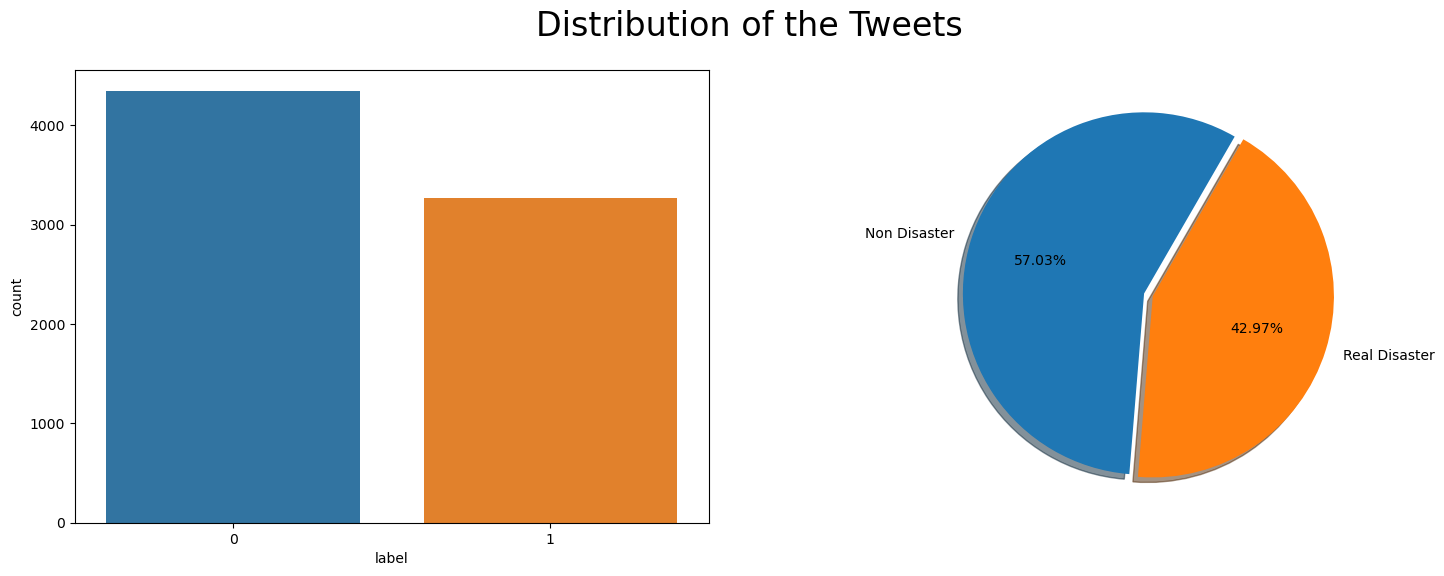

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(df['label'], ax=axes[0])
axes[1].pie(df['label'].value_counts(),
            labels=['Non Disaster', 'Real Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

# Split the dataset for `training` and `testing`

We then split the dataset for training and testing.

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df)               # Default split ratio 75/25, we can modify using "test_size"
train.to_csv("dataset/train.csv", index=False)
test.to_csv("dataset/test.csv", index=False)

### Upload both to Amazon S3 for use later

The SageMaker Python SDK provides a helpful function for uploading to Amazon S3:

In [20]:
inputs_train = sagemaker_session.upload_data("dataset/train.csv", bucket=bucket, key_prefix=prefix)
inputs_test = sagemaker_session.upload_data("dataset/test.csv", bucket=bucket, key_prefix=prefix)

# Amazon SageMaker Training

## Amazon SageMaker

- When running a training job, SageMaker reads input data from Amazon S3, uses that data to train a model. 
- Training data from S3 is made available to the Model Training instance container, which is pulled from Amazon Elastic Container Registry(`ECR`). 
- The training job persists model artifacts back to the output S3 location designated in the training job configuration. 
- When we are ready to deploy a model, SageMaker spins up new ML instances and pulls in these model artifacts to use for batch or real-time model inference.

<img src = "img/sm-training.png" >

## Training script

We use the [PyTorch-Transformers library](https://pytorch.org/hub/huggingface_pytorch-transformers), which contains PyTorch implementations and pre-trained model weights for many NLP models, including BERT.

Our training script should save model artifacts learned during training to a file path called `model_dir`, as stipulated by the SageMaker PyTorch image. Upon completion of training, model artifacts saved in `model_dir` will be uploaded to S3 by SageMaker and will become available in S3 for deployment.

We save this script in a file named `train_deploy.py`, and put the file in a directory named `code/`. The full training script can be viewed under `code/`.

In [21]:
!pygmentize code/train_deploy.py

import argparse
import json
import logging
import os
import sys

import numpy as np
import pandas as pd
import torch
import torch.distributed as dist
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from transformers import AdamW, BertForSequenceClassification, BertTokenizer
import ast
import itertools as itr

import time

import json
import boto3
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

MAX_LEN = 64  # this is the max length of the sentence

print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def _get_train_data_loader(batch_size, training_dir, is_distributed):
    logger.info(

# Train on Amazon SageMaker

We use Amazon SageMaker to train and deploy a model using our custom PyTorch code. The Amazon SageMaker Python SDK makes it easier to run a PyTorch script in Amazon SageMaker using its PyTorch estimator. After that, we can use the SageMaker Python SDK to deploy the trained model and run predictions. For more information on how to use this SDK with PyTorch, see [the SageMaker Python SDK documentation](https://sagemaker.readthedocs.io/en/stable/using_pytorch.html).

To start, we use the `PyTorch` estimator class to train our model. When creating our estimator, we make sure to specify a few things:

* `entry_point`: the name of our PyTorch script. It contains our training script, which loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model. It also contains code to load and run the model during inference.
* `source_dir`: the location of our training scripts and requirements.txt file. "requirements.txt" lists packages you want to use with your script.
* `framework_version`: the PyTorch version we want to use

The PyTorch estimator supports multi-machine, distributed PyTorch training. To use this, we just set train_instance_count to be greater than one. Our training script supports distributed training for only GPU instances. 

After creating the estimator, we then call fit(), which launches a training job. We use the Amazon S3 URIs where we uploaded the training data earlier.

<img src = "img/sm-estimator.png" >

In [22]:
! pip install --upgrade sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.4/568.4 KB 49.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.107.0-py2.py3-none-any.whl size=784128 sha256=ac3f93c6b42671572f7379a07c06a824562336ec9e327a9d8becbdd141f76f31
  Stored in directory: /home/ec2-user/.cache/pip/wheels/49/84/d6/be7707e36d08706ead27ebc97a732eff8b739f05b1387bf8aa
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.106.0
    Uninstalling sagemaker-2.106.0:
      Successfully uninstalled sagemaker-2.106.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [44]:
from sagemaker.pytorch import PyTorch

# 1. Defining the estimator 

estimator = PyTorch(entry_point="train_deploy.py",
                    source_dir="code",
                    role=role,
                    framework_version="1.12.0",
                    py_version="py38",
                    instance_count=2,                          # Distributed training for GPU instances.
                    instance_type="ml.p3.16xlarge",             # Type of instance we want the training to happen
                    hyperparameters={"epochs": 2,
                                     "num_labels": 2,
                                     "backend": "nccl",        # gloo and tcp for cpu instances - gloo and nccl for gpu instances
                                    },
                    debugger_hook_config=False,  # deactivate debugger to avoid warnings in model artifact
                    disable_profiler=True,  # keep running resources to a minimum to avoid permission errors
                    distribution={"pytorchddp":{"enabled": True}},
                   )

# 2. Start the Training 

estimator.fit({"training": inputs_train, "testing": inputs_test})


2022-08-31 23:03:44 Starting - Starting the training job.........
2022-08-31 23:04:51 Starting - Preparing the instances for training.........
2022-08-31 23:06:39 Downloading - Downloading input data...
2022-08-31 23:06:58 Training - Downloading the training image...........................
2022-08-31 23:11:38 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-31 23:11:44,200 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-31 23:11:44,650 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-08-31 23:11:44,727 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-31 23:11:44,730 sagemaker_pytorch_container.t